## Synopsis
This code generates the final figure for the SAXS results, including the normalized global scaled SAXS and fits of SAXS at each temperature, using the Lorentian function: 

$$ \large I = \frac{I_{q_0}}{1+(\xi(T) \cdot q)^\eta} $$  

Here, $\xi(T)$ is the characteristic length at temperature $T$, and $I_{q_0}$ corresponds to the SAXS intensity at $q=0$.  

The fitting is done in 3 steps:

1. Use $\eta$ from `SAXS_Scale_Fit`, fit SAXS at every temperature with the Lorentian to determine $I_{q_0}(T)$ and $\xi(T)$.
2. Fit $I_{q_0}(T)$ and $\xi(T)$ over $a \cdot (T-T_0)^b$ to determine the critical temperature $T_0$.
3. Assemble the figure.

### Initialize

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
import csv
from scipy.optimize import minimize
from matplotlib.lines import Line2D
from utils import preprocess_data, normalize_scaled_curves, optimize_T0_log, lorentzian_fit_fix_b, lorentzian_fit

### Loading the scaled curve from `SAXS_Global_Scale` and the raw data from `8IDI_reduced_H06`

In [2]:


with open('SAXS_Global_Scale.pickle', 'rb') as f:
    scaling_results = pickle.load(f)
    scaled_curves = pickle.load(f)

    
with open('8IDI_reduced_H06.pickle', 'rb') as f:
    avg_ramp_up = pickle.load(f)
    avg_ramp_down = pickle.load(f)
    t_el = pickle.load(f)
    ql_sta = pickle.load(f)
    ql_dyn = pickle.load(f)



### Clean up the data and perform fit on SAXS at all temperatures

In [3]:


avg_ramp_up_cleaned, ql_sta_cleaned = preprocess_data(avg_ramp_up, ql_sta)


# Fit each curve and also extract uncertainties from the covariance matrix.
fitted_parameters = []
fitted_errors = []
for i, (q, data) in enumerate(zip(ql_sta_cleaned, avg_ramp_up_cleaned)):
    I = data['saxs_1d']
    try:
        popt, pcov = curve_fit(lorentzian_fit_fix_b, q, I, p0=[np.max(I), 1],
                               bounds=([0, 0], [np.inf, np.inf]))
        Iq0_fit, x_fit = popt
        # Extract errors from the diagonal of the covariance matrix.
        Iq0_err, x_err = np.sqrt(np.diag(pcov))
        fitted_parameters.append((Iq0_fit, x_fit))
        fitted_errors.append((Iq0_err, x_err))
    except RuntimeError:
        continue
        
        
# Normalize the merged data
normalized_q, normalized_i = normalize_scaled_curves(scaled_curves)

# Filter out non-positive values to avoid NaN issues
valid_indices = normalized_q > 0
filtered_x = normalized_q[valid_indices]
filtered_y = normalized_i[valid_indices]

# Fit using scattering function with b as a free parameter
popt, pcov = curve_fit(lorentzian_fit, filtered_x, filtered_y, p0=[np.max(filtered_y), 1, 1.7], bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))

Iq0_fit, x_fit, b_fit = popt
x_fit_err = np.sqrt(np.diag(pcov))[1]
extended_x = np.linspace(filtered_x.min(), filtered_x.max(), 500)
fitted_y = lorentzian_fit(extended_x, Iq0_fit, x_fit, b_fit)
scaled_x = filtered_x * x_fit
extended_scaled_x = extended_x * x_fit


        

In [4]:

print(fitted_parameters[0])


(0.19491127341635178, 59.27421933184664)


NameError: name 'scaled_x' is not defined

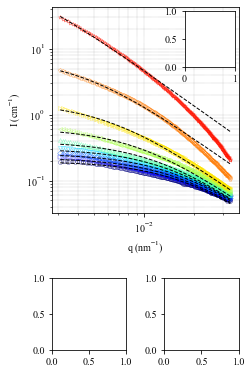

In [5]:

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 8
plt.rcParams['figure.dpi'] = 600

figure_width_mm = 86
figure_width_inches = figure_width_mm / 25.4

# --------------------------
# Plotting setup for main figure with 3 subplots
fig = plt.figure(figsize=(figure_width_inches, figure_width_inches * 1.5), constrained_layout=True)
gs = fig.add_gridspec(2, 2, height_ratios=[2, 0.7], width_ratios=[1, 1], hspace=0.1)
ax1 = fig.add_subplot(gs[0, :])  # Subplot (a)
ax2 = fig.add_subplot(gs[1, 0])  # Subplot (b)
ax3 = fig.add_subplot(gs[1, 1])  # Subplot (c)

# Colormap and marker style
cmap = plt.get_cmap('jet')
total_curves = len(ql_sta_cleaned)
colors = [cmap(i / total_curves) for i in range(total_curves)]
marker_styles = ['o', 's', 'D', 'v', '^', '<', '>', 'p', '*']

# Plot subplot (a): scattering data and fits
for i, (q, data) in enumerate(zip(ql_sta_cleaned, avg_ramp_up_cleaned)):
    ax1.loglog(q, data['saxs_1d'], marker_styles[i % len(marker_styles)], 
               color=colors[i], markersize=4, markerfacecolor='none', markeredgewidth=0.3)
for i, (q, fitted_I) in enumerate([] if not fitted_parameters else [
        (q, lorentzian_fit_fix_b(q, *fitted_parameters[i])) for i, q in enumerate(ql_sta_cleaned)]):
    ax1.loglog(q, fitted_I, '--', color='black', linewidth=1)

ax1.set_xlabel('q ($\\mathdefault{nm^{-1}}$)')
ax1.set_ylabel('I (cm$^\\mathdefault{-1}$)')
ax1.grid(which='both', linestyle=':', linewidth=0.4, color='gray')


# Inset for Normalized and Fitted Curve in subplot (a)
ax_inset = ax1.inset_axes([0.71, 0.71, 0.27, 0.27])  # Position inset
for i in range(8):
    start_idx = i * 259
    end_idx = (i + 1) * 259
    ax_inset.loglog(scaled_x[start_idx:end_idx], filtered_y[start_idx:end_idx], 'o', color=colors[i], markersize=0.5)
ax_inset.loglog(extended_scaled_x, fitted_y, color='black', linewidth=0.5)
ax_inset.set_xlabel(f'q*a (err= {x_fit_err:.3f})', fontsize=8)
ax_inset.set_ylabel(r'I(q)/I$_{q0}$', fontsize=8)
ax_inset.tick_params(axis='both', which='major', labelsize=8)
ax_inset.grid(which='both', linestyle=':', linewidth=0.4, color='gray')




NameError: name 'temperatures' is not defined

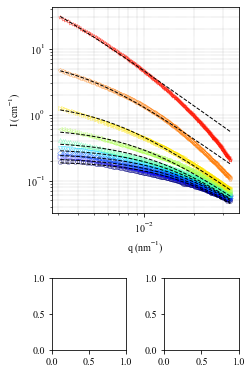

In [4]:

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
import csv
from scipy.optimize import minimize
from matplotlib.lines import Line2D
from utils import preprocess_data, normalize_scaled_curves, optimize_T0_log, lorentzian_fit_fix_b, lorentzian_fit
with open('SAXS_Global_Scale.pickle', 'rb') as f:
    scaling_results = pickle.load(f)
    scaled_curves = pickle.load(f)

    
with open('8IDI_reduced_H06.pickle', 'rb') as f:
    avg_ramp_up = pickle.load(f)
    avg_ramp_down = pickle.load(f)
    t_el = pickle.load(f)
    ql_sta = pickle.load(f)
    ql_dyn = pickle.load(f)



avg_ramp_up_cleaned, ql_sta_cleaned = preprocess_data(avg_ramp_up, ql_sta)


# Fit each curve and also extract uncertainties from the covariance matrix.
fitted_parameters = []
fitted_errors = []
for i, (q, data) in enumerate(zip(ql_sta_cleaned, avg_ramp_up_cleaned)):
    I = data['saxs_1d']
    try:
        popt, pcov = curve_fit(lorentzian_fit_fix_b, q, I, p0=[np.max(I), 1],
                               bounds=([0, 0], [np.inf, np.inf]))
        Iq0_fit, x_fit = popt
        # Extract errors from the diagonal of the covariance matrix.
        Iq0_err, x_err = np.sqrt(np.diag(pcov))
        fitted_parameters.append((Iq0_fit, x_fit))
        fitted_errors.append((Iq0_err, x_err))
    except RuntimeError:
        continue
        
        
# Normalize the merged data
normalized_q, normalized_i = normalize_scaled_curves(scaled_curves)

# Filter out non-positive values to avoid NaN issues
valid_indices = normalized_q > 0
filtered_x = normalized_q[valid_indices]
filtered_y = normalized_i[valid_indices]

# Fit using scattering function with b as a free parameter
popt, pcov = curve_fit(lorentzian_fit, filtered_x, filtered_y, p0=[np.max(filtered_y), 1, 1.7], bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))

Iq0_fit, x_fit, b_fit = popt
x_fit_err = np.sqrt(np.diag(pcov))[1]
extended_x = np.linspace(filtered_x.min(), filtered_x.max(), 500)
fitted_y = lorentzian_fit(extended_x, Iq0_fit, x_fit, b_fit)
scaled_x = filtered_x * x_fit
extended_scaled_x = extended_x * x_fit
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 8
plt.rcParams['figure.dpi'] = 600

figure_width_mm = 86
figure_width_inches = figure_width_mm / 25.4

# --------------------------
# Plotting setup for main figure with 3 subplots
fig = plt.figure(figsize=(figure_width_inches, figure_width_inches * 1.5), constrained_layout=True)
gs = fig.add_gridspec(2, 2, height_ratios=[2, 0.7], width_ratios=[1, 1], hspace=0.1)
ax1 = fig.add_subplot(gs[0, :])  # Subplot (a)
ax2 = fig.add_subplot(gs[1, 0])  # Subplot (b)
ax3 = fig.add_subplot(gs[1, 1])  # Subplot (c)

# Colormap and marker style
cmap = plt.get_cmap('jet')
total_curves = len(ql_sta_cleaned)
colors = [cmap(i / total_curves) for i in range(total_curves)]
marker_styles = ['o', 's', 'D', 'v', '^', '<', '>', 'p', '*']

# Plot subplot (a): scattering data and fits
for i, (q, data) in enumerate(zip(ql_sta_cleaned, avg_ramp_up_cleaned)):
    ax1.loglog(q, data['saxs_1d'], marker_styles[i % len(marker_styles)], 
               color=colors[i], markersize=4, markerfacecolor='none', markeredgewidth=0.3)
for i, (q, fitted_I) in enumerate([] if not fitted_parameters else [
        (q, lorentzian_fit_fix_b(q, *fitted_parameters[i])) for i, q in enumerate(ql_sta_cleaned)]):
    ax1.loglog(q, fitted_I, '--', color='black', linewidth=1)

ax1.set_xlabel('q ($\\mathdefault{nm^{-1}}$)')
ax1.set_ylabel('I (cm$^\\mathdefault{-1}$)')
ax1.grid(which='both', linestyle=':', linewidth=0.4, color='gray')
# Legend
legend_elements = [
    Line2D([0], [0], marker=marker_styles[i % len(marker_styles)], color=colors[i], label=f'{temperatures[i]:.1f}($^\circ$C)',
           markersize=4, linewidth=0.4, linestyle='None', markerfacecolor='none', markeredgewidth=0.3)
    for i in range(len(fitted_parameters))
]
ax1.legend(handles=legend_elements, loc='lower left', fontsize=7, frameon=True, ncol=3, labelspacing=0.3, handletextpad=-0.2, columnspacing=-0.1)

# Normalize and fit inset data (remains unchanged)


# Filter out non-positive values to avoid NaN issues
valid_indices = normalized_q > 0
filtered_x = normalized_q[valid_indices]
filtered_y = normalized_i[valid_indices]

# Fit using scattering function with b as a free parameter
popt, pcov = curve_fit(lorentzian_fit, filtered_x, filtered_y, p0=[np.max(filtered_y), 1, 1.7], bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))

Iq0_fit, x_fit, b_fit = popt
x_fit_err = np.sqrt(np.diag(pcov))[1]
extended_x = np.linspace(filtered_x.min(), filtered_x.max(), 500)
fitted_y = lorentzian_fit(extended_x, Iq0_fit, x_fit, b_fit)
scaled_x = filtered_x * x_fit
extended_scaled_x = extended_x * x_fit

# Inset for Normalized and Fitted Curve in subplot (a)
ax_inset = ax1.inset_axes([0.71, 0.71, 0.27, 0.27])  # Position inset
for i in range(8):
    start_idx = i * 259
    end_idx = (i + 1) * 259
    ax_inset.loglog(scaled_x[start_idx:end_idx], filtered_y[start_idx:end_idx], 'o', color=colors[i], markersize=0.5)
ax_inset.loglog(extended_scaled_x, fitted_y, color='black', linewidth=0.5)
ax_inset.set_xlabel(f'q*a (err= {x_fit_err:.3f})', fontsize=8)
ax_inset.set_ylabel(r'I(q)/I$_{q0}$', fontsize=8)
ax_inset.tick_params(axis='both', which='major', labelsize=8)
ax_inset.grid(which='both', linestyle=':', linewidth=0.4, color='gray')

# --------------------------
# Extract temperature and fitted parameter arrays
# (Assumes each entry in avg_ramp_up has a 'temperature' key.)
t = [np.nanmean(avg_dict['temperature']) for avg_dict in avg_ramp_up]
temperatures = np.array(t[:-1])
if len(fitted_parameters) != len(temperatures):
    raise ValueError("Mismatch between fitted parameters and temperatures!")
Iq0_values, x_values = zip(*fitted_parameters)
Iq0_errors, x_errors = zip(*fitted_errors)
Iq0_values = np.array(Iq0_values)
x_values = np.array(x_values)
Iq0_errors = np.array(Iq0_errors)
x_errors = np.array(x_errors)


best_T0, best_T0_err = optimize_T0_log(temperatures, x_values, x_errors, initial_delta=1.0, num_samples=1000)
# print("Optimized T0:", best_T0, "+/-", best_T0_err)

# --------------------------
# Prepare data for subplots (b) and (c)
T_diff = best_T0 - temperatures

# Fit power laws in log–log space for Iq0 vs (T0-T) and x vs (T0-T)
log_T_diff = np.log(T_diff)
log_Iq0 = np.log(Iq0_values)
slope_I, intercept_I = np.polyfit(log_T_diff, log_Iq0, 1)
A_I = np.exp(intercept_I)
Iq0_fit_curve = A_I * (T_diff ** slope_I)

log_x = np.log(x_values)
slope_x, intercept_x = np.polyfit(log_T_diff, log_x, 1)
A_x = np.exp(intercept_x)
x_fit_curve = A_x * (T_diff ** slope_x)

# Generate smooth curves for plotting.
T_diff_fit = np.linspace(np.min(T_diff), np.max(T_diff), 100)
Iq0_fit_line = A_I * (T_diff_fit ** slope_I)
x_fit_line = A_x * (T_diff_fit ** slope_x)

# --------------------------
# Subplot (b): Iq0 vs (T0-T)
for i in range(len(T_diff)):
    ax2.errorbar(T_diff[i], Iq0_values[i], yerr=Iq0_errors[i]*10, fmt=marker_styles[i % len(marker_styles)], 
                 color=colors[i], markersize=5, markerfacecolor='none', markeredgewidth=0.2, linewidth=0, elinewidth=1.2)
ax2.plot(T_diff_fit, Iq0_fit_line, '--', color='black', linewidth=0.6, label="_nolegend_")
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('T0 - T', fontsize=7)
ax2.set_ylabel('Iq0', fontsize=7)
ax2.tick_params(axis='both', which='major', labelsize=7)
ax2.grid(which='both', linestyle=':', linewidth=0.4, color='gray')
ax2.legend([f'T0: {best_T0:.1f}±{best_T0_err:.2f}\nPower: {slope_I:.2f}'], 
           fontsize=7, frameon=True, handlelength=1, handletextpad=0.3, 
           borderpad=0.2, labelspacing=0.2, loc="upper right")

# --------------------------
# Subplot (c): x vs (T0-T)
for i in range(len(T_diff)):
    ax3.errorbar(T_diff[i], x_values[i], yerr=x_errors[i]*10, fmt=marker_styles[i % len(marker_styles)], 
                 color=colors[i], markersize=5, markerfacecolor='none', markeredgewidth=0.2, linewidth=0, elinewidth=1.2)
ax3.plot(T_diff_fit, x_fit_line, '--', color='black', linewidth=0.6, label="_nolegend_")
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel('T0 - T', fontsize=7)
ax3.set_ylabel('x', fontsize=7)
ax3.tick_params(axis='both', which='major', labelsize=7)
ax3.yaxis.set_label_coords(-0.15, 0.5)
ax3.grid(which='both', linestyle=':', linewidth=0.4, color='gray')
ax3.legend([f'T0: {best_T0:.1f}±{best_T0_err:.2f}\nPower: {slope_x:.2f}'], fontsize=7,  handlelength=1, handletextpad=0.3, 
           borderpad=0.2, labelspacing=0.2, frameon=True)

# --------------------------
# Add figure labels
fig.text(0.03, 1.01, '(a)', fontsize=7, fontweight='bold', va='top', ha='left')
fig.text(0.03, 0.32, '(b)', fontsize=7, fontweight='bold', va='top', ha='left')
fig.text(0.57, 0.32, '(c)', fontsize=7, fontweight='bold', va='top', ha='left')

# Save and display the figure
plt.savefig('fitting.pdf', bbox_inches="tight", dpi=600)
plt.show()